导入包

In [1]:
import sys
sys.path.append(r"I:/1-ML/工况合集")
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import  DataLoader
import numpy as np
import matplotlib.pyplot as plt
from utils.PDE_Net import DeepONet_NS, FNO2d, weight_init
from utils.DataGenerate_FNO import Dataset_FNO, Normalize, InNormalize, get_file
from argparse import Namespace
from utils.utilities3 import *
import time

torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

设置超参数

In [56]:

dx = 0.5
n_x = int(8/dx)
n_y = int(3/dx)
p_x = int(800/n_x+1)
p_y = int(300/n_y+1)
self_split = 2

config = Namespace(
	project_name = 'FNO',
	epochs = 100,
	
	dx = dx,
	n_x = n_x,
	n_y = n_y,
	p_x = p_x,
	p_y = p_y,
	self_split = self_split,

	path_trained_model = r'trained_model',
	path_distance = r'../train_data/distance',
	path_label = r'../train_data/label',
	path_distance_test = r'../test_data/distance',
	path_label_test = r'../test_data/label',

	batch_size = 150,
	modes = 12,
	width = 40,

	activation = 'Sigmoid',
# activation = torch.nn.__dict__[wandb.config.activation]()
# optimizer = torch.optim.__dict__[wandb.config.optim_type](params=model.parameters(), lr=wandb.config.learning_rate)
	optim_type = 'SGD',
	learning_rate = 0.0026392500276311696,
	dropout = 0,
	weight_decay = 0.00035181732255007376,
	max_norm = 3.637374450623043,
)

test_distance = np.load(r'I:\1-ML\工况合集\data\original_distance_data\train_distance_data_2.npy')
test_label = np.load(r'I:\1-ML\工况合集\data\original_labels_data\2.npy')
# test_data = np.load(r'truth_test.npy')
test_distance = torch.Tensor(test_distance)
test_label = torch.Tensor(test_label)

高斯归一化

In [57]:
x_normalizer = GaussianNormalizer(test_distance)
x_data = x_normalizer.encode(test_distance)
y_normalizer = GaussianNormalizer(test_label)
y_data = y_normalizer.encode(test_label)

In [58]:
print(x_data.shape)
print(y_data.shape)

torch.Size([96, 51, 51, 3])
torch.Size([96, 51, 51, 1])


导入模型

In [59]:
activation = torch.nn.__dict__[config.activation]()
model = FNO2d(config.modes, config.modes, config.width, activation, config.dropout)
optimizer = torch.optim.__dict__[config.optim_type](params=model.parameters(), lr=config.learning_rate)
myloss = nn.MSELoss()
begin_epoch = 0

读取模型

In [60]:
file_list = os.listdir(config.path_trained_model)
file_list.sort()
if len(file_list) > 0:
	last_model = get_file(config.path_trained_model)[-1]
load_path = os.path.join(last_model)
print(load_path)
# load_path = r'I:\ML\Package_model\DeepONet\FNO_distance\trained_model\FNO_distance_width_100_inout_5000_time_model_input3.pth'
begin_epoch = load_model(load_path, optimizer, model)
model.to(device)

trained_model\FNO_5dataset_0.5m_split4_100.pth
Load model at epoch: 100


FNO2d(
  (func): Sigmoid()
  (p): Linear(in_features=5, out_features=40, bias=True)
  (conv0): SpectralConv2d()
  (conv1): SpectralConv2d()
  (conv2): SpectralConv2d()
  (conv3): SpectralConv2d()
  (mlp0): MLP(
    (mlp1): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1))
    (mlp2): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1))
    (func): Sigmoid()
  )
  (mlp1): MLP(
    (mlp1): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1))
    (mlp2): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1))
    (func): Sigmoid()
  )
  (mlp2): MLP(
    (mlp1): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1))
    (mlp2): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1))
    (func): Sigmoid()
  )
  (mlp3): MLP(
    (mlp1): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1))
    (mlp2): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1))
    (func): Sigmoid()
  )
  (w0): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1))
  (w1): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1))
  (w2): Conv2d(40, 40, kerne

读取数据

In [61]:
# dataset = Dataset(data_dir,is_pred=False,split=2,is_save=False,datafile=datafile)
# data_x, data_y = dataset.getitem()
# print(data_x.shape)
# data_x, mean_x, std_x = Normalize(data_x)
# data_y, mean_y, std_y = Normalize(data_y)
test_loader = DataLoader(torch.utils.data.TensorDataset(x_data, y_data), batch_size=config.batch_size, shuffle=False)
# test_loader = DataLoader(torch.utils.data.TensorDataset(train_data, truth_data), batch_size=batch_size, shuffle=True)
x, y = next(iter(test_loader))
print(torch.max(x))
print(torch.max(y))

tensor(1.5463)
tensor(3.9792)


进行预测

In [62]:
start_time = time.time()
model.eval()
with torch.no_grad():

	loss_train = 0
	data_x,data_y = next(iter(test_loader))

	x = data_x.float().to(device)			# [length,time_step,51,51,3]
	y = data_y.float().to(device)			# [length,time_step,51,51,3]

	pred = model(x)												# x:[length,51,51,3], pred:[length,51,51,3]

	pred = y_normalizer.decode(pred)
	y_test = y_normalizer.decode(y)
	
	loss_train = myloss(pred.clone(), y_test.clone())
	end_time = time.time()
print(pred.shape)
print(loss_train)
print('time cost:', end_time-start_time)

torch.Size([96, 51, 51, 1])
tensor(0.0108, device='cuda:0')
time cost: 0.007066249847412109


little pcolor plot

In [28]:
coordinate = np.meshgrid(np.linspace(0,dx,p_x), np.linspace(0,dx,p_y))
coordinate = np.stack((coordinate[0],coordinate[1]), axis=-1).reshape(-1,2)

coordinate = torch.Tensor(coordinate).to(device)


xx = coordinate.cpu().detach().numpy()[:,0].reshape(51,51)
yy = coordinate.cpu().detach().numpy()[:,1].reshape(51,51)
print(xx.shape)

(51, 51)


[]

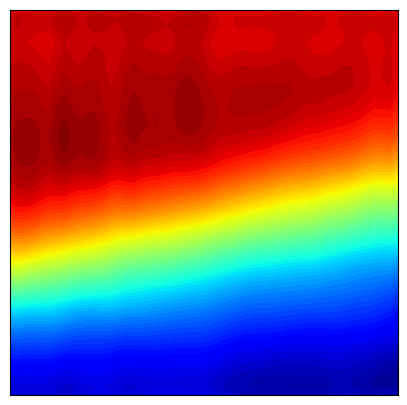

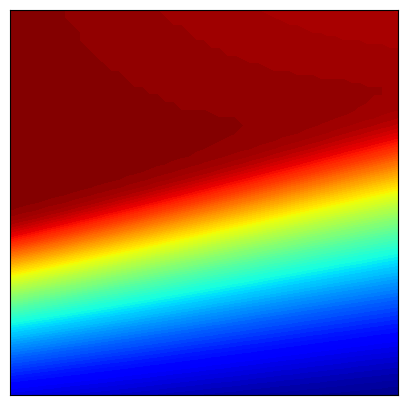

In [12]:
index = 22
x = pred.cpu().detach().numpy()[index].reshape(51,51)
y = y_test.cpu().detach().numpy()[index].reshape(51,51)
fig,axs = plt.subplots(1,1,figsize=(5,5))
axs.contourf(xx,yy,x,100,cmap='jet')
x1_min, x1_max = axs.get_xlim()
y1_min, y1_max = axs.get_ylim()
axs.set_xticks([])
axs.set_yticks([])
fig,axs = plt.subplots(1,1,figsize=(5,5))
axs.contourf(xx,yy,y,100,cmap='jet')
axs.set_xlim(x1_min, x1_max)
axs.set_ylim(y1_min, y1_max)
axs.set_xticks([])
axs.set_yticks([])

(96, 51, 51, 1)


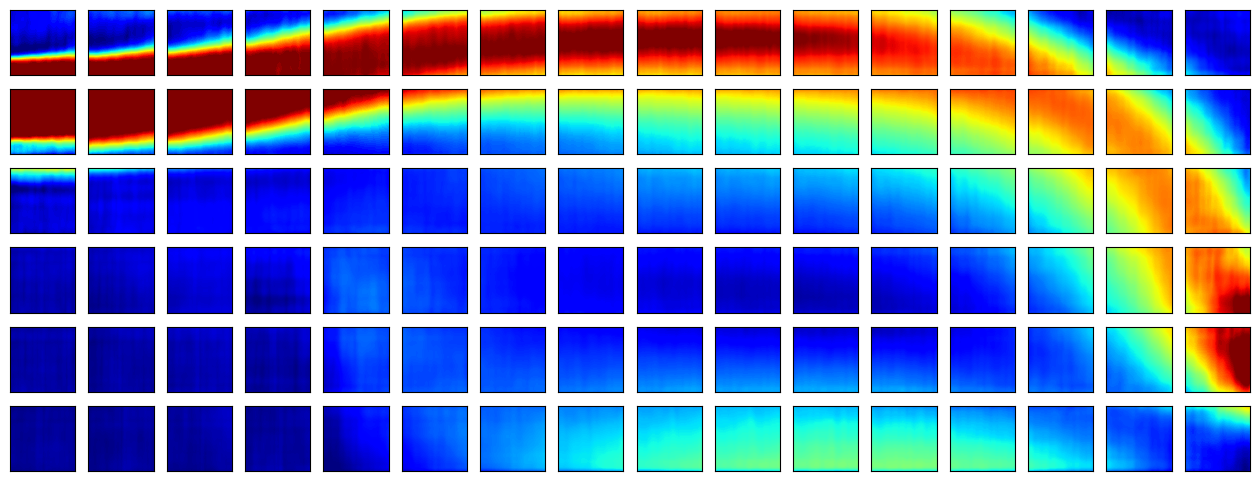

In [63]:
# pred = train_normalizer.decode(pred)
test_x = pred.cpu().detach().numpy()
# test_x[42, :, :, :] = 0
# test_x[43, :, :, :] = 0
# test_x[48, :, :, :] = 0
# test_x[49, :, :, :] = 0
# test_x[9, :, 51:, :] = 0
# test_x[12, :, :51, :] = 0
coordinate = np.meshgrid(np.linspace(0,dx,p_x),np.linspace(0,dx,p_y))
fig,axs = plt.subplots(n_y,n_x,figsize=(16,6))
print(test_x.shape)
for i in range(n_y):
	for j in range(n_x):
		axs[(n_y-1)-i,j].contourf(coordinate[0], coordinate[1], test_x[i+j*n_y,:,:,0], 100, cmap='jet', vmin=0, vmax=1)
		axs[(n_y-1)-i,j].set_aspect('equal')
		axs[(n_y-1)-i,j].set_xticks([])
		axs[(n_y-1)-i,j].set_yticks([])


plt.show()

(96, 51, 51, 1)


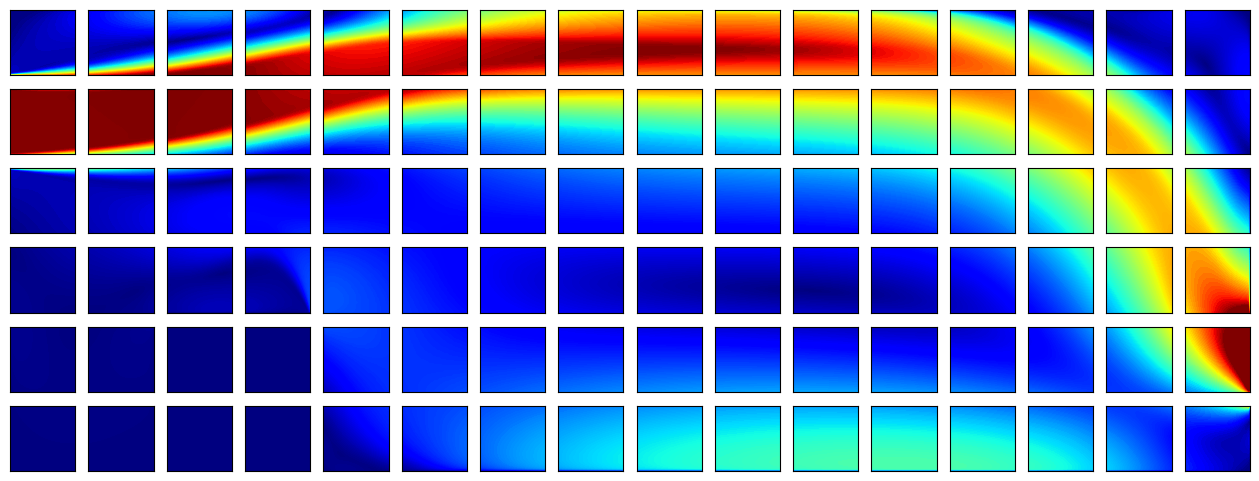

In [64]:
# 真实结果
fig,axs = plt.subplots(n_y,n_x,figsize=(16,6))
print(test_x.shape)
for i in range(n_y):
	for j in range(n_x):
		axs[(n_y-1)-i,j].contourf(coordinate[0], coordinate[1], test_label[i+j*n_y,:,:,0], 100, cmap='jet', vmin=0, vmax=1)
		axs[(n_y-1)-i,j].set_aspect('equal')
		axs[(n_y-1)-i,j].set_xticks([])
		axs[(n_y-1)-i,j].set_yticks([])


plt.show()

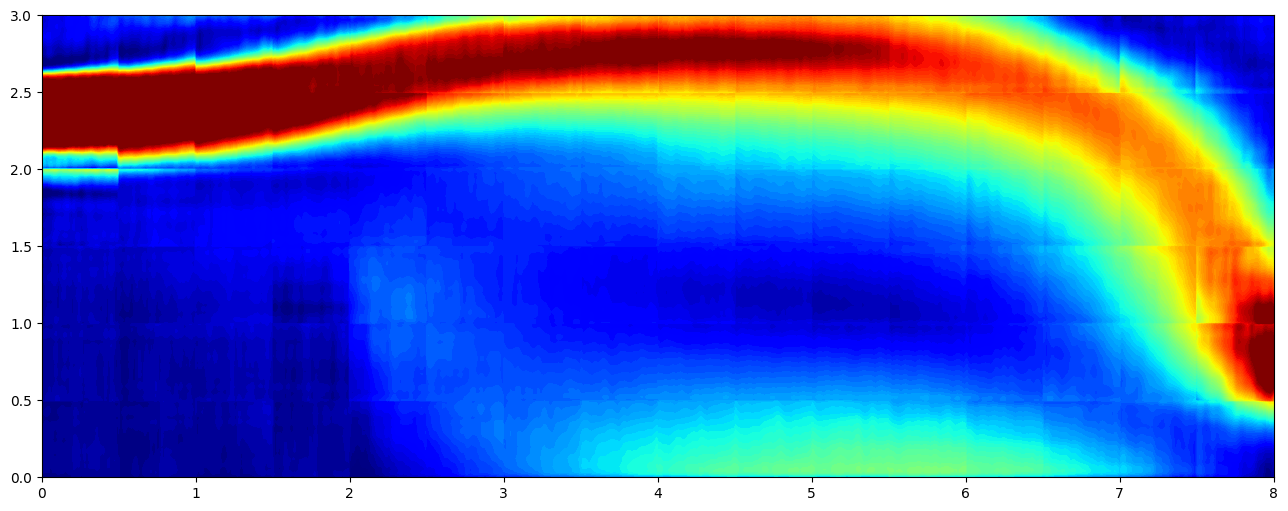

In [65]:
all_zone = np.zeros((300,800))
for i in range(n_y):
	for j in range(n_x):
		if i == n_y-1 and j != n_x-1:
			all_zone[-(p_x):,j*(p_y-1):(j+1)*(p_y-1)+1] = test_x[i+j*(n_y),:,:,0]
		elif i != n_y-1 and j == n_x-1:
			all_zone[i*(p_x-1):(i+1)*(p_x-1)+1,-(p_y):] = test_x[i+j*(n_y),:,:,0]
		elif i == n_y-1 and j == n_x-1:
			all_zone[-(p_x):,-(p_y):] = test_x[i+j*(n_y),:,:,0]
		else:
			all_zone[i*(p_x-1):(i+1)*(p_x-1)+1,j*(p_y-1):(j+1)*(p_y-1)+1] = test_x[i+j*(n_y),:,:,0]

fig,axs = plt.subplots(1,figsize=(n_x,n_y))
axs.contourf(np.linspace(0,8,800),np.linspace(0,3,300),all_zone,100,cmap='jet',vmin=0,vmax=1)
axs.set_aspect('equal')

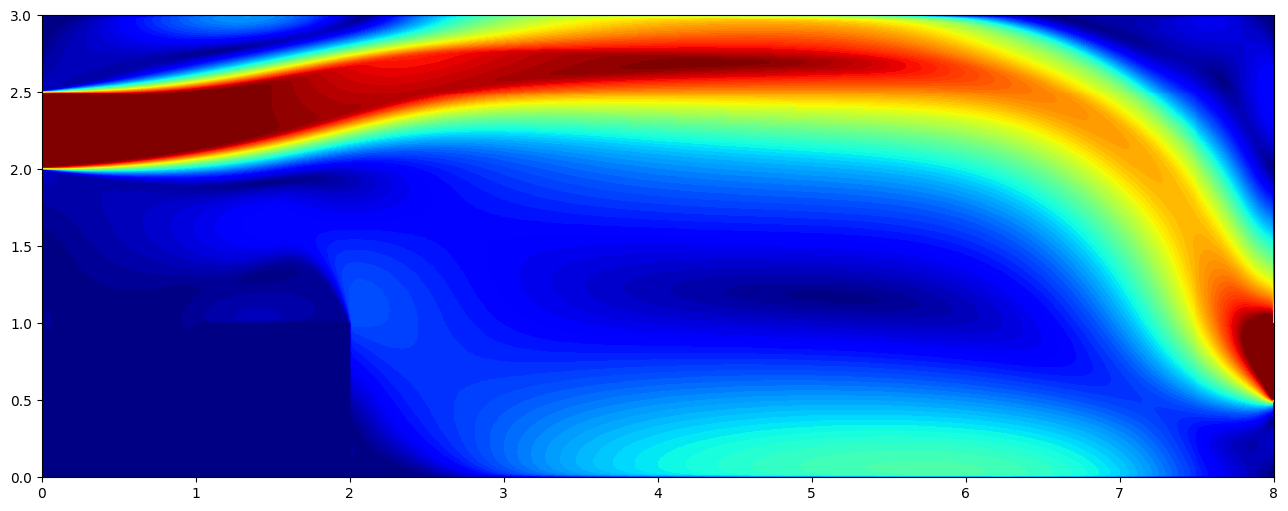

In [66]:
all_zone_truth = np.zeros((300,800))
for i in range(n_y):
	for j in range(n_x):
		if i == n_y-1 and j != n_x-1:
			all_zone_truth[-(p_x):,j*(p_y-1):(j+1)*(p_y-1)+1] = test_label[i+j*(n_y),:,:,0]
		elif i != n_y-1 and j == n_x-1:
			all_zone_truth[i*(p_x-1):(i+1)*(p_x-1)+1,-(p_y):] = test_label[i+j*(n_y),:,:,0]
		elif i == n_y-1 and j == n_x-1:
			all_zone_truth[-(p_x):,-(p_y):] = test_label[i+j*(n_y),:,:,0]
		else:
			all_zone_truth[i*(p_x-1):(i+1)*(p_x-1)+1,j*(p_y-1):(j+1)*(p_y-1)+1] = test_label[i+j*(n_y),:,:,0]

fig,axs = plt.subplots(1,figsize=(n_x,n_y))
axs.contourf(np.linspace(0,8,800),np.linspace(0,3,300),all_zone_truth,100,cmap='jet',vmin=0,vmax=1)
axs.set_aspect('equal')

误差云图

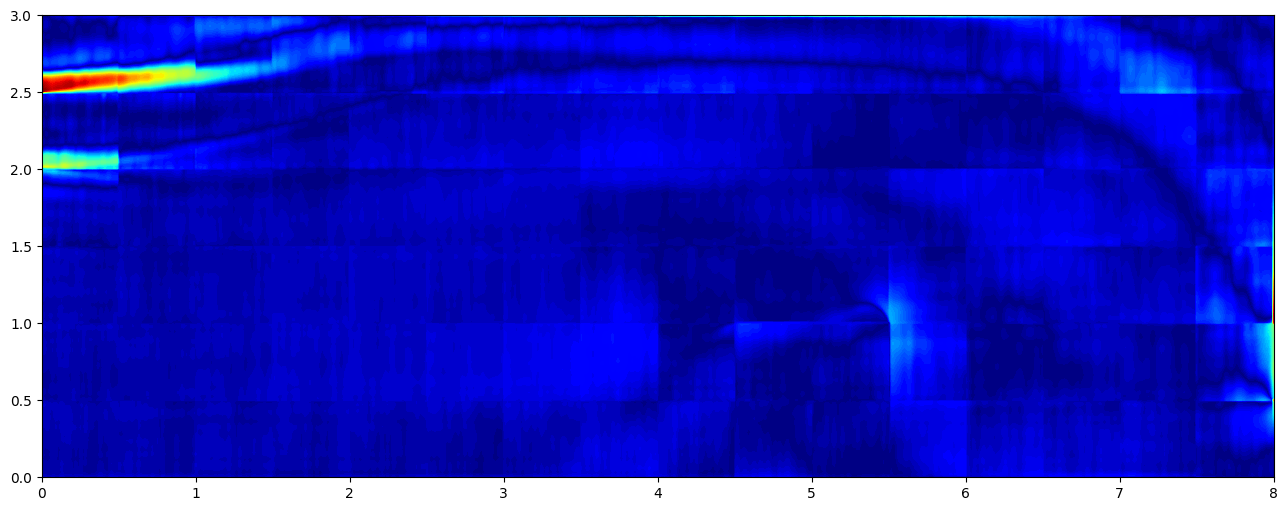

In [26]:
error = np.abs(all_zone_truth-all_zone)
fig,axs = plt.subplots(1,figsize=(16,6))
axs.contourf(np.linspace(0,8,800),np.linspace(0,3,300),error,100,cmap='jet',vmin=0,vmax=1)
axs.set_aspect('equal')

获取某条线上的值

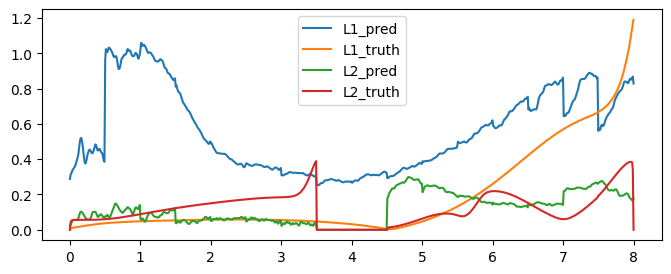

In [51]:
x1_test = all_zone[:,500]
x1_truth = all_zone_truth[:,500]
y1_test = all_zone[225,:]
y1_truth = all_zone_truth[225,:]
y2_test = all_zone[75,:]
y2_truth = all_zone_truth[75,:]
plt.figure(figsize=(8,3))
l1, = plt.plot(np.linspace(0,8,800),y1_test,label='L1_pred')
l2, = plt.plot(np.linspace(0,8,800),y1_truth,label='L1_truth')
L3, = plt.plot(np.linspace(0,8,800),y2_test,label='L2_pred')
L4, = plt.plot(np.linspace(0,8,800),y2_truth,label='L2_truth')
plt.legend(handles=[l1, l2, L3, L4], labels=['L1_pred', 'L1_truth', 'L2_pred', 'L2_truth'], loc='best')


save = False
if save:
	np.savetxt(r'I:\ML\工况合集\预测数据保存\pred_FNO.txt',all_zone)
	np.savetxt(r'I:\ML\工况合集\预测数据保存\truth.txt',all_zone_truth)

### 下采样插值

C:\Users\Administrator\AppData\Local\Temp\ipykernel_32516\314474411.py:11: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  f = interpolate.interp2d(x, y, z, kind='cubic')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_32516\314474411.py:15: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev`

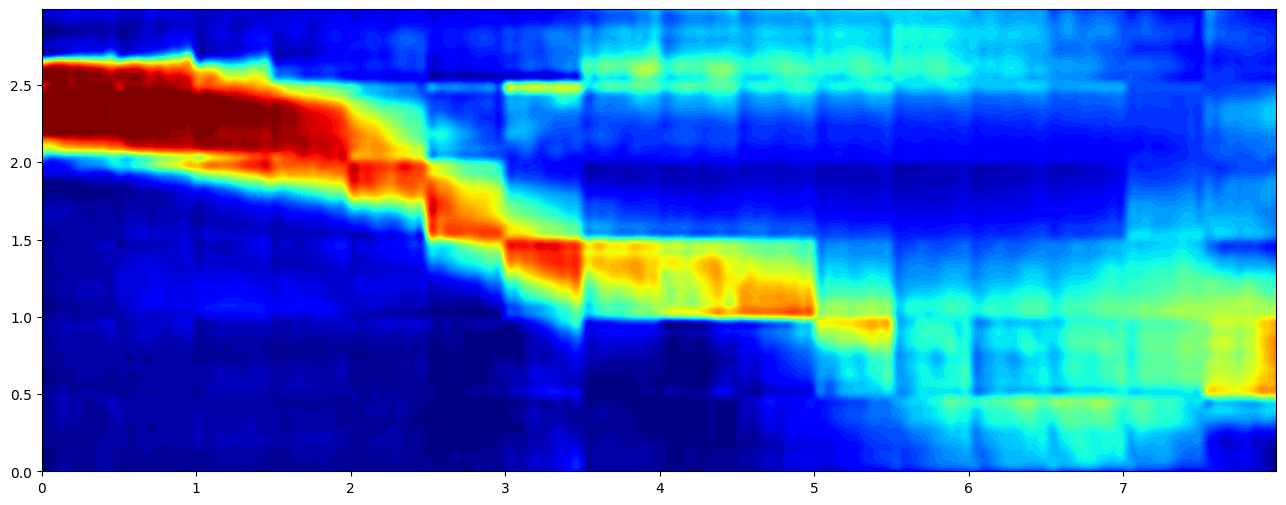

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

interval = 5
x = np.linspace(0, 8, int(800/interval))
y = np.linspace(0, 3, int(300/interval))
xx, yy = np.meshgrid(x, y) #建立原始坐标
z = all_zone[::interval,::interval]

f = interpolate.interp2d(x, y, z, kind='cubic')

xnew = np.arange(0, 8, 1e-2)
ynew = np.arange(0, 3, 1e-2)
znew = f(xnew, ynew) #插值后的数据


fig,axs = plt.subplots(1,figsize=(n_x,n_y))
axs.contourf(xnew,ynew,znew,100,cmap='jet',vmin=0,vmax=1)
axs.set_aspect('equal')

### 滤波

[]

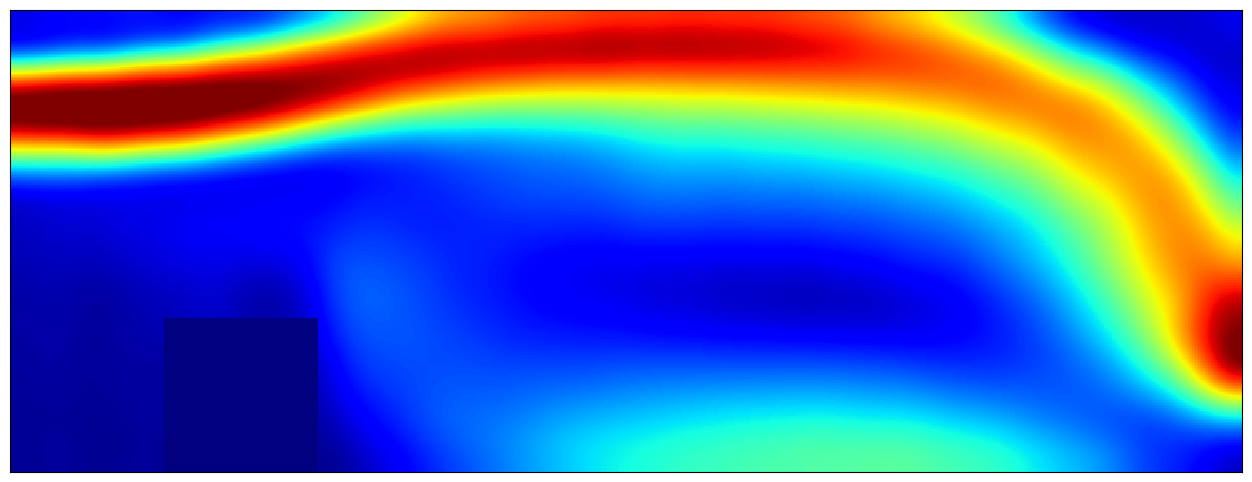

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt2d, convolve2d, savgol_filter
from scipy.ndimage import gaussian_filter
from scipy.fft import fft2, ifft2

# 准备数据集
data = all_zone  # 二维矩阵，形状为 (300, 800)

# 中值滤波
# smoothed_data = medfilt2d(data, kernel_size=9)

# 高斯加权平均滤波
sigma = 12  # 高斯滤波的标准差
smoothed_data = gaussian_filter(data, sigma=sigma)

# 移动平均法滤波处理
# window_size = 20  # 移动平均窗口的大小
# kernel = np.ones((window_size, window_size)) / (window_size**2)
# smoothed_data = convolve2d(data, kernel, mode='same')

# 加权平均法滤波处理
# weights = np.array([[1, 2, 1],
#                     [2, 10, 2],
#                     [1, 2, 1]])  # 加权平均的权重矩阵
# weights = weights / np.sum(weights)  # 归一化权重矩阵
# smoothed_data = convolve2d(data, weights, mode='same')

# Savitzky-Golay滤波处理
# window_size = 50  # 滤波窗口的大小
# poly_order = 2  # 多项式拟合的阶数
# smoothed_data = savgol_filter(data, window_length=window_size, polyorder=poly_order)

# 傅里叶变换
# f_data = fft2(data)

# # 频域滤波（在此示例中，假设我们想去除低频分量，保留高频分量）
# cutoff = 1  # 截止频率
# f_data[np.abs(f_data) < cutoff] = 0

# # 逆傅里叶变换
# smoothed_data = np.real(ifft2(f_data))

# 绘制等高线图
xnew = np.arange(0, 8, 1e-2)
ynew = np.arange(0, 3, 1e-2)

smoothed_data[:100, 100:200] = 0
fig,axs = plt.subplots(1,figsize=(16,6))
axs.pcolor(xnew,ynew,smoothed_data,cmap='jet',vmin=0,vmax=1)
axs.set_aspect('equal')
axs.set_xticks([])
axs.set_yticks([])

误差云图

[]

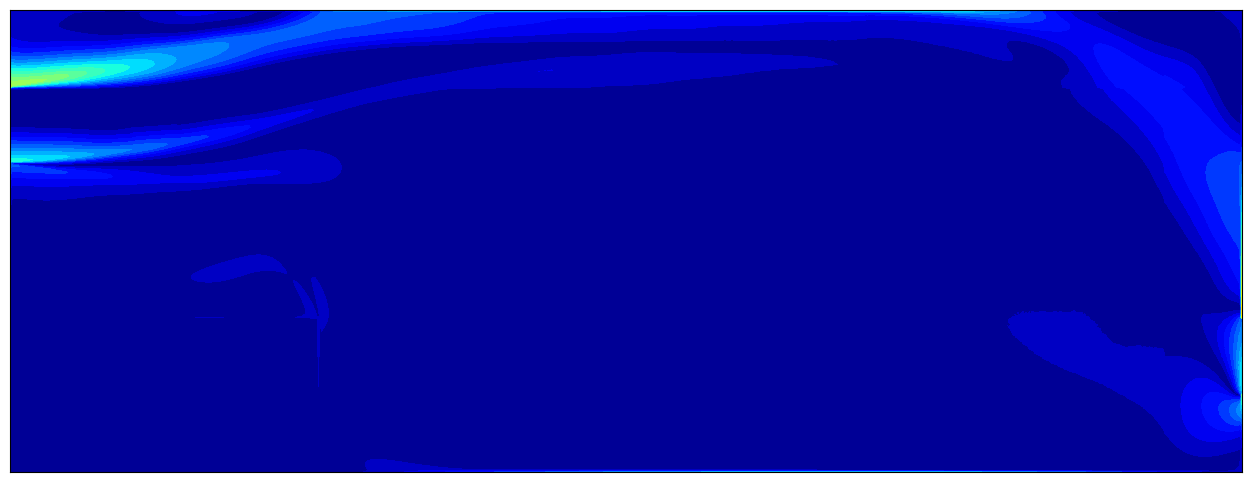

In [68]:
error = np.abs(all_zone_truth-smoothed_data)/np.max(all_zone_truth)
fig,axs = plt.subplots(1,figsize=(16,6))
coontour = axs.contourf(np.linspace(0,8,800),np.linspace(0,3,300),error,20,cmap='jet',vmin=0,vmax=1)
axs.set_aspect('equal')
axs.set_xticks([])
axs.set_yticks([])
# colorbar = fig.colorbar(coontour)

# 杂项

### 用DeepONet重构结果

In [107]:
DNO_repred_data = test_x
bc_left = DNO_repred_data[:, :, 0, :]
bc_right = DNO_repred_data[:, :, -1, :]
bc_top = DNO_repred_data[:, -1, :, :]
bc_bottom = DNO_repred_data[:, 0, :, :]
bc = np.concatenate((bc_left, bc_top, bc_right, bc_bottom), axis=1)
DON_model = DeepONet_NS([204, 512, 512, 512, 512, 512], [2, 16, 64, 256, 512, 512, 512])
DON_optimizer = optim.Adam(DON_model.parameters(), lr=learning_rate, weight_decay=1e-4)
DON_save_path = r'I:\ML\Package_model\DeepONet\original_model\trained_model\original_DON_48000_4000.pth'
saved_epoch = load_model(DON_save_path, DON_optimizer, DON_model)

Load model at epoch: 4000


In [108]:
coordinate = np.meshgrid(np.linspace(0,dx,p_x),np.linspace(0,dx,p_y))
coordinate = np.stack(coordinate, axis=-1).reshape(-1,2)
print(bc.shape)
print(coordinate.shape)

(96, 204, 1)
(2601, 2)


In [109]:
DON_model.to(device)
DON_pred = DON_model(torch.Tensor(bc[...,0]).to(device), torch.Tensor(coordinate).to(device))
DON_pred = DON_pred.cpu().detach().numpy()

(96, 51, 51, 1)


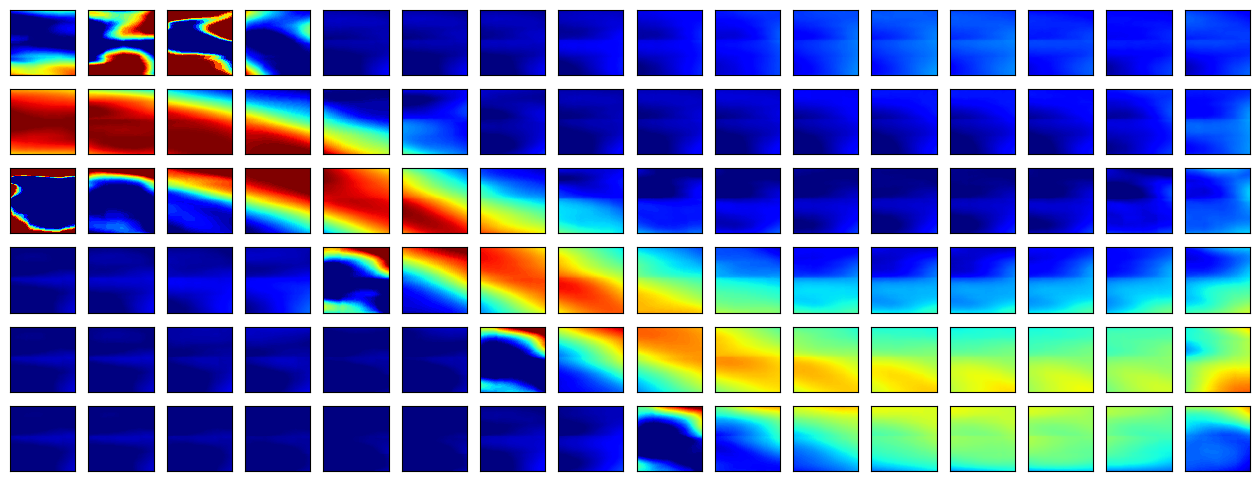

In [110]:
DON_pred = DON_pred.reshape(-1,p_x,p_y,1)
coordinate = np.meshgrid(np.linspace(0,dx,p_x),np.linspace(0,dx,p_y))
fig,axs = plt.subplots(n_y,n_x,figsize=(n_x,n_y))
print(DON_pred.shape)
for i in range(n_y):
	for j in range(n_x):
		axs[(n_y-1)-i,j].contourf(coordinate[0], coordinate[1], DON_pred[i+j*(n_y),:,:,0], 100, cmap='jet', vmin=0, vmax=1)
		axs[(n_y-1)-i,j].set_aspect('equal')
		axs[(n_y-1)-i,j].set_xticks([])
		axs[(n_y-1)-i,j].set_yticks([])


plt.show()

Locator attempting to generate 9378 ticks ([-2.934, ..., 11.131499999999999]), which exceeds Locator.MAXTICKS (1000).


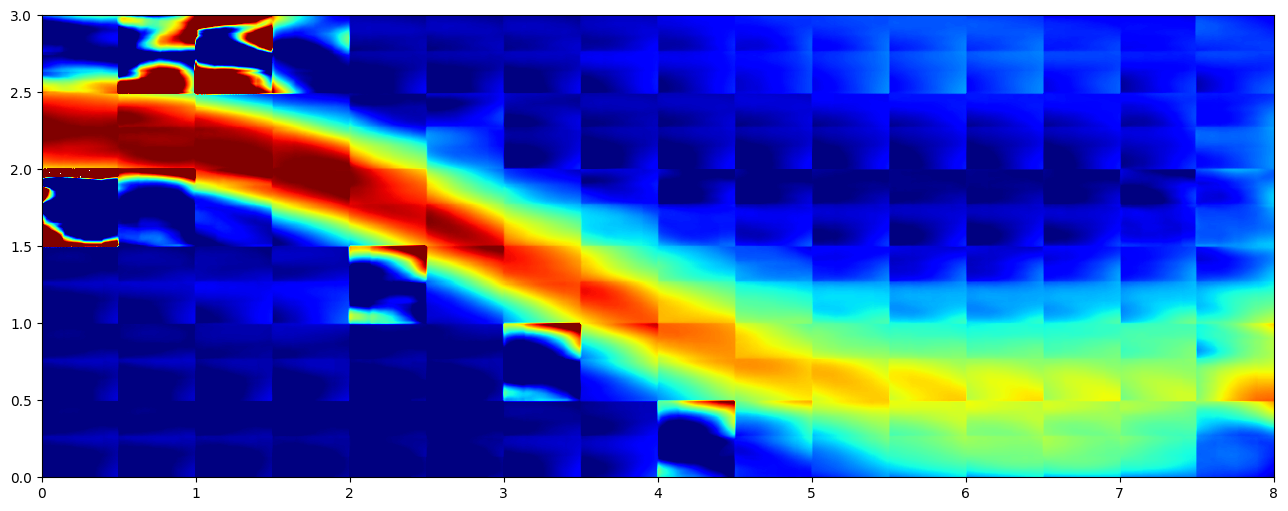

In [111]:
all_zone_DNO = np.zeros((300,800))
for i in range(n_y):
	for j in range(n_x):
		if i == n_y-1 and j != n_x-1:
			all_zone_DNO[-(p_x):,j*(p_y-1):(j+1)*(p_y-1)+1] = DON_pred[i+j*(n_y),:,:,0]
		elif i != n_y-1 and j == n_x-1:
			all_zone_DNO[i*(p_x-1):(i+1)*(p_x-1)+1,-(p_y):] = DON_pred[i+j*(n_y),:,:,0]
		elif i == n_y-1 and j == n_x-1:
			all_zone_DNO[-(p_x):,-(p_y):] = DON_pred[i+j*(n_y),:,:,0]
		else:
			all_zone_DNO[i*(p_x-1):(i+1)*(p_x-1)+1,j*(p_y-1):(j+1)*(p_y-1)+1] = DON_pred[i+j*(n_y),:,:,0]

fig,axs = plt.subplots(1,figsize=(n_x,n_y))
axs.contourf(np.linspace(0,8,800),np.linspace(0,3,300),all_zone_DNO,10000,cmap='jet',vmin=0,vmax=1)
axs.set_aspect('equal')

Locator attempting to generate 8777 ticks ([-1.6602000000000001, ..., 3.6054]), which exceeds Locator.MAXTICKS (1000).


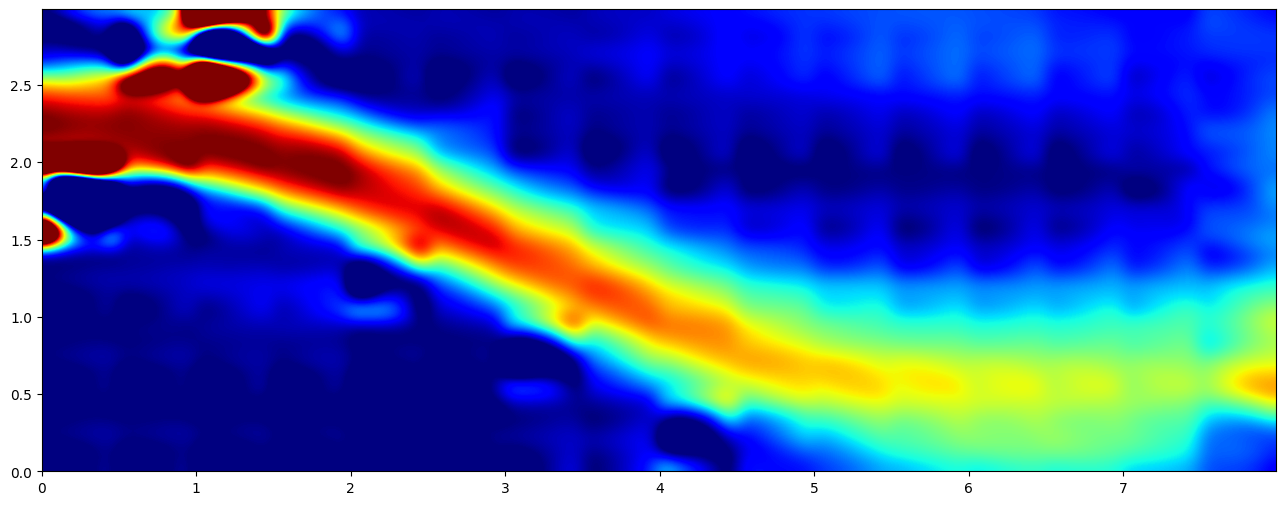

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt2d, convolve2d, savgol_filter
from scipy.ndimage import gaussian_filter
from scipy.fft import fft2, ifft2

# 准备数据集
data = all_zone_DNO  # 二维矩阵，形状为 (300, 800)

# 中值滤波
# smoothed_data = medfilt2d(data, kernel_size=9)

# 高斯加权平均滤波
sigma = 6  # 高斯滤波的标准差
smoothed_data = gaussian_filter(data, sigma=sigma)

# 移动平均法滤波处理
# window_size = 20  # 移动平均窗口的大小
# kernel = np.ones((window_size, window_size)) / (window_size**2)
# smoothed_data = convolve2d(data, kernel, mode='same')

# 加权平均法滤波处理
# weights = np.array([[1, 2, 1],
#                     [2, 10, 2],
#                     [1, 2, 1]])  # 加权平均的权重矩阵
# weights = weights / np.sum(weights)  # 归一化权重矩阵
# smoothed_data = convolve2d(data, weights, mode='same')

# Savitzky-Golay滤波处理
# window_size = 50  # 滤波窗口的大小
# poly_order = 2  # 多项式拟合的阶数
# smoothed_data = savgol_filter(data, window_length=window_size, polyorder=poly_order)

# 傅里叶变换
# f_data = fft2(data)

# # 频域滤波（在此示例中，假设我们想去除低频分量，保留高频分量）
# cutoff = 1  # 截止频率
# f_data[np.abs(f_data) < cutoff] = 0

# # 逆傅里叶变换
# smoothed_data = np.real(ifft2(f_data))

# 绘制等高线图
xnew = np.arange(0, 8, 1e-2)
ynew = np.arange(0, 3, 1e-2)

fig,axs = plt.subplots(1,figsize=(n_x,n_y))
axs.contourf(xnew,ynew,smoothed_data,10000,cmap='jet',vmin=0,vmax=1)
axs.set_aspect('equal')

#### 势场获得速度场（无用）

(96, 51, 51, 1)


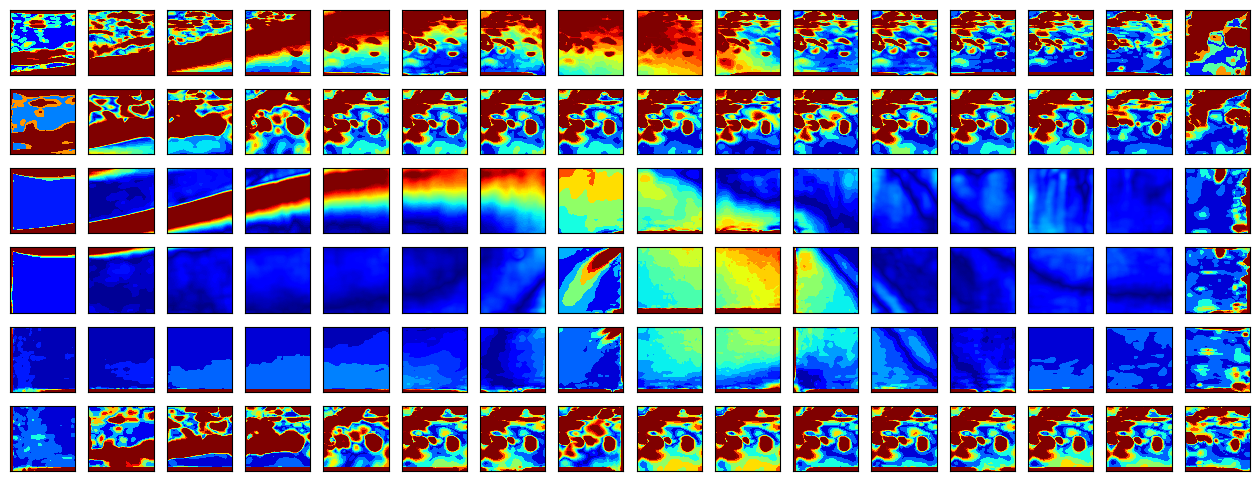

In [13]:
def solve_velocity(vorticity):
    # 计算速度场的分量 u = ∂ψ/∂y，v = -∂ψ/∂x
    u = np.gradient(-vorticity, axis=1)
    v = np.gradient(vorticity, axis=0)

    return u, v

# 求解速度场
u, v = solve_velocity(test_x)
mag = np.sqrt(u**2 + v**2)
print(mag.shape)
# 绘制速度场
fig,axs = plt.subplots(n_y,n_x,figsize=(n_x,n_y))
for i in range(n_y):
	for j in range(n_x):
		axs[(n_y-1)-i,j].contourf(coordinate[0], coordinate[1], mag[i+j*(n_y),:,:,0], 100, cmap='jet', vmin=0, vmax=1)
		axs[(n_y-1)-i,j].set_aspect('equal')
		axs[(n_y-1)-i,j].set_xticks([])
		axs[(n_y-1)-i,j].set_yticks([])


plt.show()

(96, 51, 51, 1)


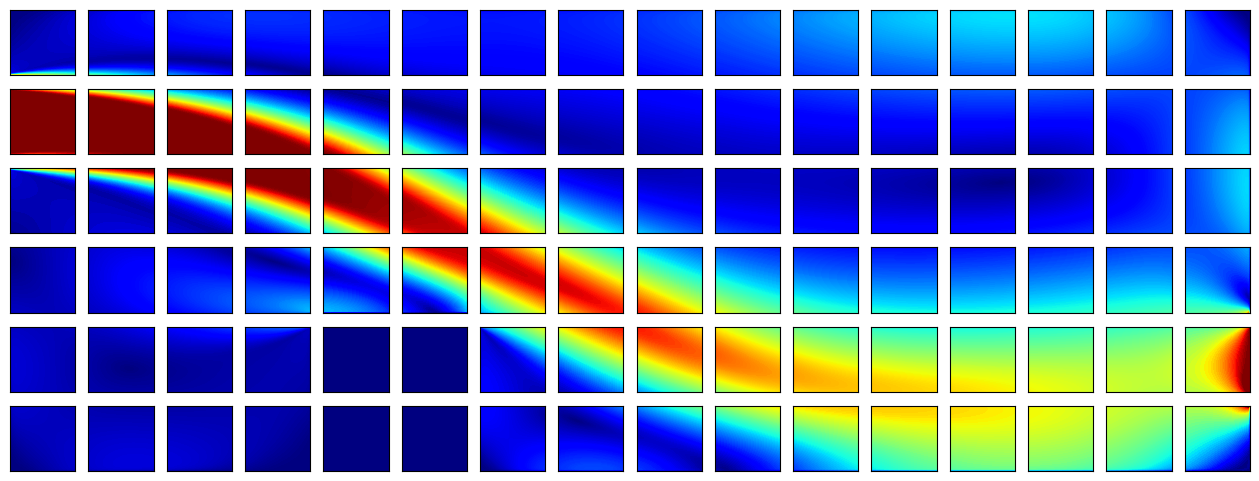

In [20]:
train_data = train_data.cpu().detach().numpy()

coordinate = np.meshgrid(np.linspace(0,0.5,51),np.linspace(0,0.5,51))
fig,axs = plt.subplots(6,16,figsize=(16,6))
print(train_data.shape)
for i in range(6):
	for j in range(16):
		axs[5-i,j].contourf(coordinate[0], coordinate[1], train_data[i+j*6,:,:,0], 100, cmap='jet', vmin=0, vmax=1)
		axs[5-i,j].set_aspect('equal')
		axs[5-i,j].set_xticks([])
		axs[5-i,j].set_yticks([])


plt.show()

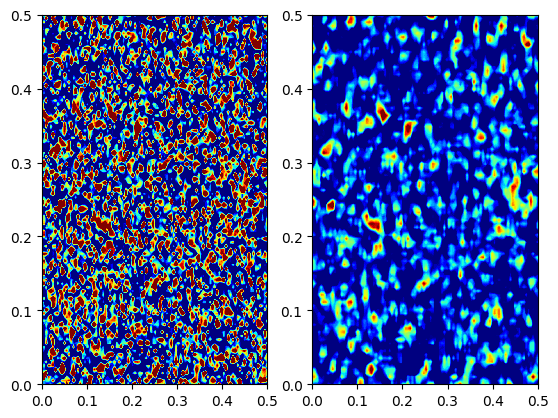

In [60]:
import numpy as np
import scipy.ndimage as ndimage

# 定义速度分布矩阵
velocity = np.random.randn(100, 100)
coordinate = np.meshgrid(np.linspace(0,0.5,100),np.linspace(0,0.5,100))
fig,axs = plt.subplots(1,2)
axs[0].contourf(coordinate[0], coordinate[1], velocity, 100, cmap='jet', vmin=0, vmax=1)

# 定义平滑窗口大小
window_size = 3

# 使用移动平均滤波器进行平滑处理
smoothed_velocity = ndimage.uniform_filter(velocity, size=window_size)

# 打印平滑后的速度分布矩阵
# print(smoothed_velocity)

axs[1].contourf(coordinate[0], coordinate[1], smoothed_velocity, 100, cmap='jet', vmin=0, vmax=1)


In [23]:
coordinate = np.meshgrid(np.linspace(0,0.5,51), np.linspace(0,0.5,51))
coordinate = np.stack((coordinate[0],coordinate[1]), axis=-1).reshape(-1,2)
print(coordinate.shape)

(2601, 2)
